# Week 8 - K-Nearest Neighbors 

This notebook focuses on concepts such as K-Nearest Neighbors.

In this notebook, I will dive into using K-Nearest Neighbors (KNN) regression to predict hospital length of stay. I will test out different numbers of neighbors (k) and distance metrics to see what gives us the best results. The main goals is to tune the model for accuracy and see how well it can predict on new, unseen data using metrics like RMSE and R².

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

Load the data.

In [2]:
df = pd.read_csv('LengthOfStay.csv')
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


Replace '5+' with '5' and make sure all the values on the column are integers.

In [3]:
df['rcount'] = df['rcount'].replace('5+', 5)
df['rcount'] = df['rcount'].astype(int)

Drop unnecessary columns and encode categorical colummns.

In [4]:
df_clean = df.drop(columns=['eid', 'vdate', 'discharged'])

df_encoded = pd.get_dummies(df_clean, columns=['gender', 'facid'], drop_first=True)

X = df_encoded.drop(columns=['lengthofstay'])
y = df_encoded['lengthofstay']

Scale and split the data.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Build the KNN model with a k value of 5.

In [7]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 1.14
R²: 0.77


The model's predictions are about 1.14 days off and it explains 77% of the variance in LOS. It is a quite strong baseline.

Now I will iterate the model using a range of k values from 1 to 31 and plot it the results with the rmse outcomes.

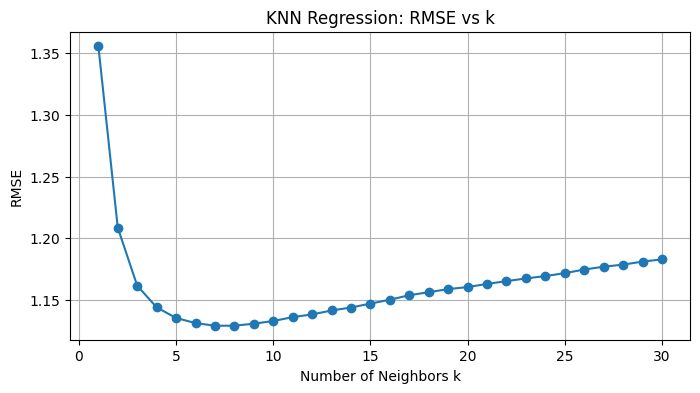

In [8]:
k_values = range(1, 31)
rmse_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, p=2)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

plt.figure(figsize=(8, 4))
plt.plot(k_values, rmse_scores, marker='o')
plt.xlabel('Number of Neighbors k')
plt.ylabel('RMSE')
plt.title('KNN Regression: RMSE vs k')
plt.grid(True)
plt.show()

The grpah indicates that the sweet spot of k value is between 6 and 8.

In [9]:
from sklearn.model_selection import GridSearchCV

Now I will use GridSearch to find the best parameters for this model, including the number of neighbors, weight of the neighbors and how the distance is measured (Euclidean or Manhattan)

In [10]:
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsRegressor()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

best_knn = grid.best_estimator_
y_pred_best = best_knn.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Best RMSE: {rmse_best:.2f}")
print(f"Best R²: {r2_best:.2f}")

Best parameters: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Best RMSE: 1.11
Best R²: 0.78


The best combination is 8 neighbors, Manhattan distance, and distance weighting, reducing RMSE to 1.11 and improving R² to 0.78. Overall, this shows that tuning KNN hyperparameters can noticeably boost prediction accuracy.